# Filter adata

In [1]:
%load_ext autoreload
%autoreload 2

import src.data as data
import src.simulation as sim
import scanpy as sc
import episcanpy as epi
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import src.plots as myplt
from pathlib import Path
import numpy as np
import scipy.stats as stats

In [2]:
file_path=Path('data/mouse_brain_5k/peak_by_cell.h5ad')

In [3]:
epidata = data.MouseBrainDataset()
# adata = epidata.load_mtx(matrix_path=Path('data/mouse_brain_5k/bin_by_cell.h5ad'))
# adata = epidata.get_window_mtx(matrix_path=Path('data/mouse_brain_5k/10000bin_by_cell.h5ad'), window_size=10000, save=True)
# adata = epidata.get_peak_mtx(matrix_path=Path('data/mouse_brain_5k/peak_by_cell.h5ad'), save=True)
adata = epidata.load_mtx(matrix_path=file_path)

In [4]:
adata

AnnData object with n_obs × n_vars = 3880 × 189587
    obs: 'cell_type', 'protocol'
    var: 'chr', 'start', 'stop'

<br><hr><br><br><h3>QC visualization + determine filtering thresholds</h3>

In [5]:
epi.pp.qc_stats(adata, verbose=True)

added keys n_cells, log_n_cells to .var
added keys n_features, log_n_features, n_counts, log_n_counts to .obs


In [6]:
epi.pp.nucleosome_signal(adata, str(epidata.fragments_file), n=10000)

In [7]:
epi.pp.tss_enrichment(adata, gtf=str(epidata.gtf_file), fragments=str(epidata.fragments_file), n=5000, score="avg_score_of_center_region", distance_to_tss=1000, bp_per_flank=100)

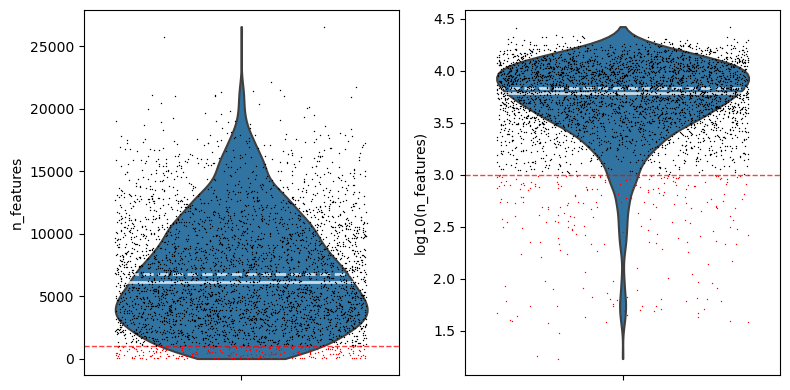

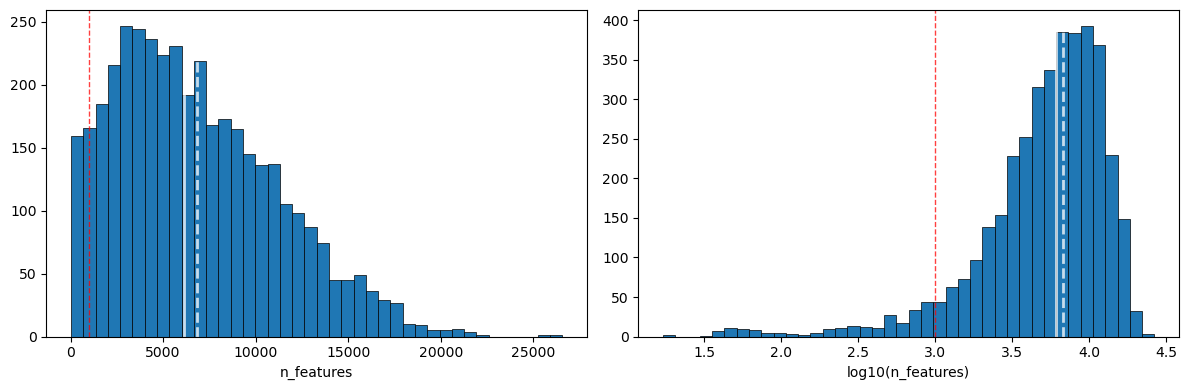

Max:	26571
Median:	6124.5
Mean:	6804.136340206185
Min:	17


In [8]:
min_features = 1000
max_features = None

epi.pl.violin(adata, "n_features", min_threshold=min_features, max_threshold=max_features, show_log=True, show_mean=True, show_median=True, print_statistics=False, save=None)
epi.pl.histogram(adata, "n_features", bins=40, min_threshold=min_features, max_threshold=max_features, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

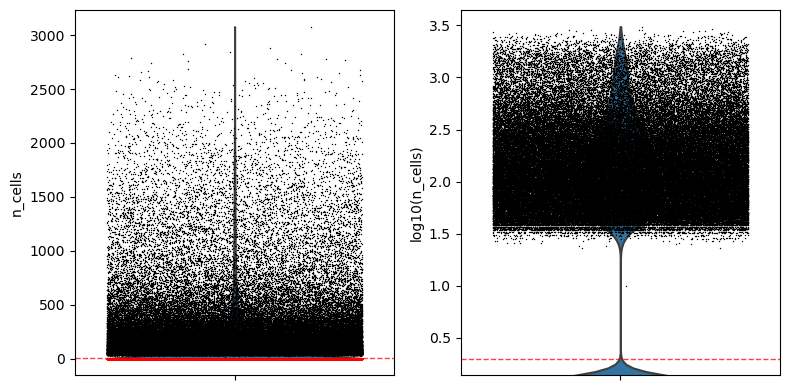

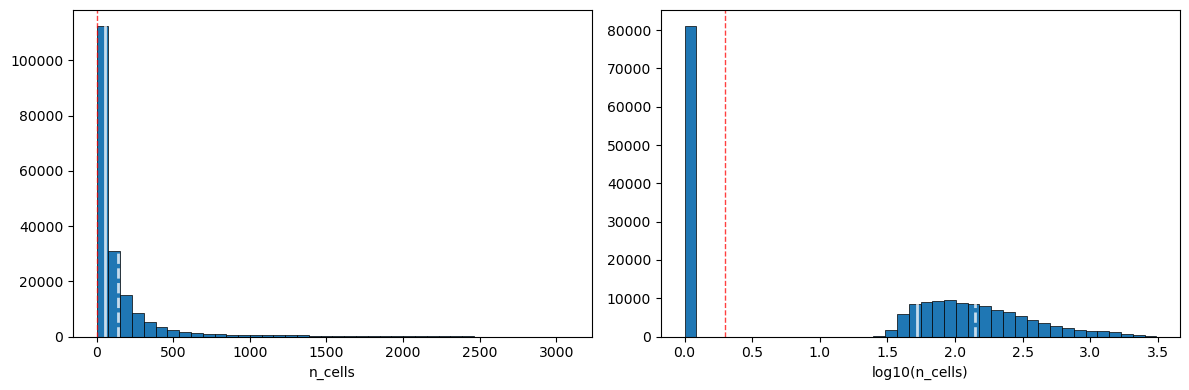

Max:	3079
Median:	52.0
Mean:	139.25031252142816
Min:	0


In [9]:
min_cells = 2
max_cells = None

epi.pl.violin(adata, "n_cells", min_threshold=min_cells, max_threshold=max_cells, show_log=True, show_mean=True, show_median=True, print_statistics=False, save=None)
epi.pl.histogram(adata, "n_cells", bins=40, min_threshold=min_cells, max_threshold=max_cells, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

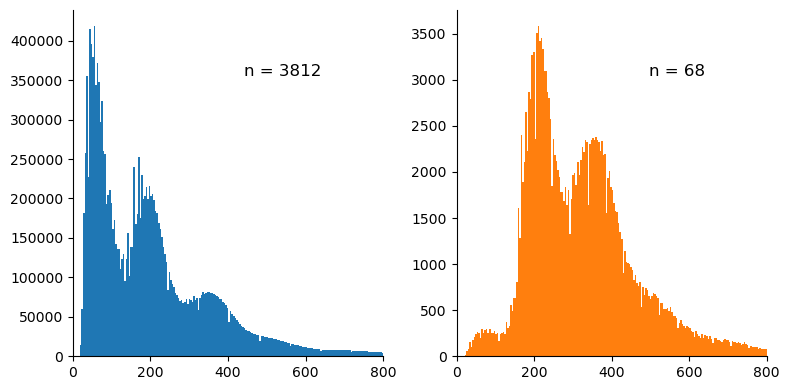

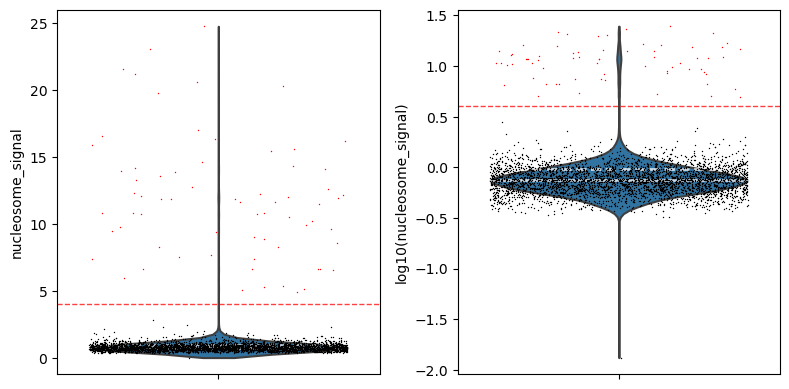

Max:	24.763636363636362
Median:	0.7455087446527191
Mean:	0.9676022149952296
Min:	0.013245033112582781


In [10]:
max_nucleosome_signal = 4

epi.pl.fragment_length(adata, n=5000, threshold=max_nucleosome_signal, show_n=True)
epi.pl.violin(adata, "nucleosome_signal", max_threshold=max_nucleosome_signal, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

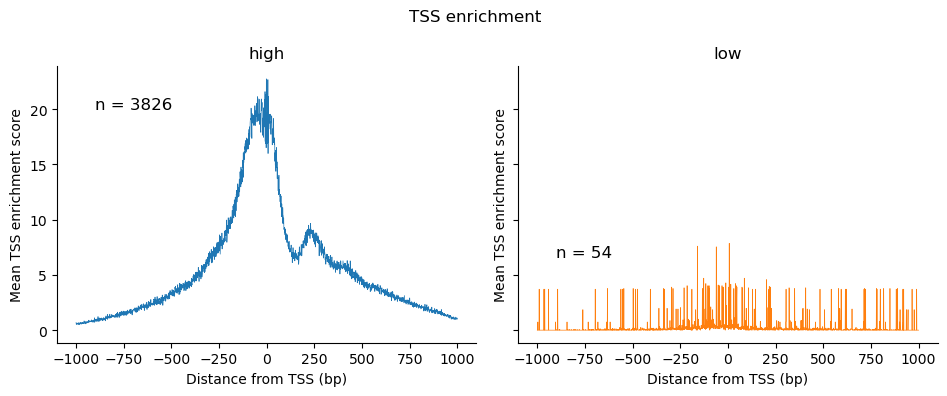

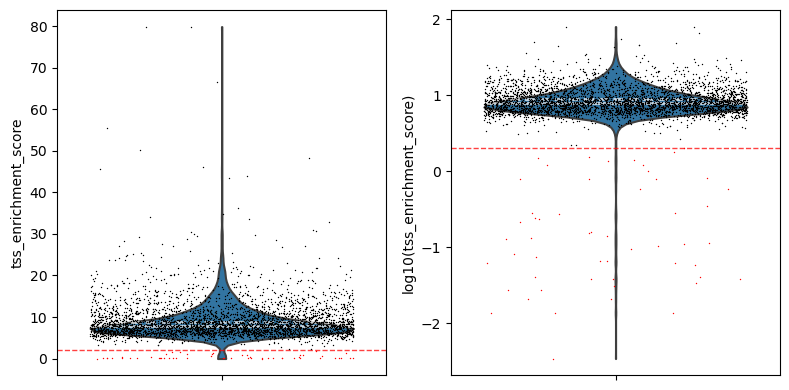

Max:	79.92007992007991
Median:	7.797021572531776
Mean:	8.879653820375259
Min:	0.0


In [11]:
min_tss_enrichment = 2

adata.obs["tss"] = ["high" if val > min_tss_enrichment else "low" for val in adata.obs.tss_enrichment_score]

epi.pl.tss_enrichment(adata, group_by="tss", show_n=True)
epi.pl.violin(adata, "tss_enrichment_score", min_threshold=min_tss_enrichment, show_log=True, show_mean=True, show_median=True, print_statistics=True, save=None)

<br><hr><br><br><h3>Set, check, and apply filters</h3>

In [12]:
epi.pp.set_filter(adata, "n_features", min_threshold=min_features, max_threshold=max_features)
epi.pp.set_filter(adata, "nucleosome_signal", max_threshold=max_nucleosome_signal)
epi.pp.set_filter(adata, "tss_enrichment_score", min_threshold=min_tss_enrichment)
epi.pp.set_filter(adata, "n_cells", min_threshold=min_cells)

3633 of 3880 observations remain (-247)
3812 of 3880 observations remain (-68)
3826 of 3880 observations remain (-54)
108390 of 189587 features remain (-81197)


In [13]:
adata = epi.pp.apply_filters(adata, verbose=True)

3577 of 3880 observations remain (-303)
108390 of 189587 features remain (-81197)


In [14]:
adata.write_h5ad(file_path.parent / (file_path.stem + '_filtered.h5ad'))